# Анализ пользователей мобильного приложения по продаже продуктов питания

В стартапе, который продаёт продукты питания, необходимо проанализировать, как ведут себя пользователи мобильного приложения. 

**Цель работы** - анализ поведения пользователей на основании изучения воронки продаж и исследования результатов A/A/B-эксперимента по изменению шрифта в приложении.

**Описание данных**

- информация о действиях пользователей (событиях) (`logs_exp.csv`):

`EventName` — название события;\
`DeviceIDHash` — уникальный идентификатор пользователя;\
`EventTimestamp` — время события;\
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import math as mt
import scipy.stats as stats
from pylab import rcParams
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# настройки для графиков
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-pastel')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('darkgrid')
sns.set_palette('Pastel1')

In [3]:
# открытие файла
data = pd.read_csv('E:\My documents\Studying\Data_Analyst\Projects\pr_10_startup\logs_exp.csv', sep='\t')

In [4]:
# вывод основной информации о датафреймах, подсчет дубликатов и пропусков
def df_info(data: pd.DataFrame):
    print('Первые 10 строк датафрейма')
    display(data.head(10))
    print('Основная информация о датафрейме')
    display(data.info())
    print('Описание данных')
    display(data.describe())
    print('Количество строк-дубликатов')
    display(data.duplicated().sum())
    print('Количество пропусков')
    display(data.isna().sum())

df_info(data)

Первые 10 строк датафрейма


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Основная информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Описание данных


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


Количество строк-дубликатов


413

Количество пропусков


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [5]:
# сохранение первоначального количества строк в переменной
old_data = data.shape[0]

На основании полученной информации можно сделать следующие выводы:
- наименования столбцов не соответствуют единому стилю;
- у столбца с временем события неверно определен тип данных;
- присутствуют явные дубликаты;
- пропуски значений в столбцах отсутствуют.

Необходима предобработка данных для устранения вышеуказанных проблем и более детальной обработки столбцов.

## Предобработка данных

In [6]:
# переименование столбцов
data = data.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_dt', 
                            'ExpId': 'exp_id'})

In [7]:
# изменение типа данных у столбца с временем события
data['event_dt'] = pd.to_datetime(data['event_dt'], unit='s')

In [8]:
# создание отдельного столбца с датой события
data['event_date'] = pd.to_datetime(data['event_dt'].dt.date)

In [9]:
# удаление дубликатов
data = data.drop_duplicates().reset_index(drop=True)

In [10]:
# проверка удаления дубликатов
data.duplicated().sum()

0

In [11]:
# расчет отношения количества строк после проведения предобработки
# к изначальному количеству строк
data.shape[0] / old_data

0.9983082506574474

Посмотрим на количество уникальных значений названий событий и номеров эксперимента.

In [12]:
# подсчет уникальных значений в столбце с названием события
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [13]:
# подсчет уникальных значений в столбце с номером эксперимента
data['exp_id'].value_counts()

248    85582
246    80181
247    77950
Name: exp_id, dtype: int64

Проверим, нет ли таких пользователей, которые попадают сразу в несколько групп эксперимента.

In [14]:
# вывод пользователей, которые попадают сразу в несколько групп
data.groupby('user_id').agg({'exp_id': 'nunique'}).query('exp_id > 1')

,exp_id
user_id,


Таким образом, в данном разделе был изменен тип данных в столбце датафрейма с временем события для корректной работы с датой и временем, добавлен отдельный столбец с датой, названия столбцов были переименованы для удобства работы, а также были устранены явные дубликаты.

Пропущенные значения и пользователи, которые попали сразу в несколько групп, обнаружены не были.

Кроме того, были рассмотрены уникальные значения столбцов с названием события и номером эксперимента.

Количество удаленных данных составило менее 1% от исходного датасета.

## Изучение и проверка данных

### Расчет количества событий, количества пользователей в логе и среднего количества событий на пользователя

In [15]:
prev_event_count = data.shape[0]
print('Всего событий в логе:', prev_event_count)
prev_user_count = data['user_id'].nunique()
print('Всего пользователей в логе:', prev_user_count)
prev_avg_count = (data['event_name'].count() / data['user_id'].nunique()).round()
print('Среднее количество событий на пользователя:', prev_avg_count)

Всего событий в логе: 243713
Всего пользователей в логе: 7551
Среднее количество событий на пользователя: 32.0


### Изучение периода времени

Посмотрим на максимальную и минимальную дату событий.

In [16]:
print('Минимальная дата события:', data['event_dt'].min())
print('Максимальная дата события:', data['event_dt'].max())

Минимальная дата события: 2019-07-25 04:43:36
Максимальная дата события: 2019-08-07 21:15:17


В датасете присутствуют данные с 25 июля по 7 августа 2019 года.

Посмотрим на распределение количества событий по датам и времени.

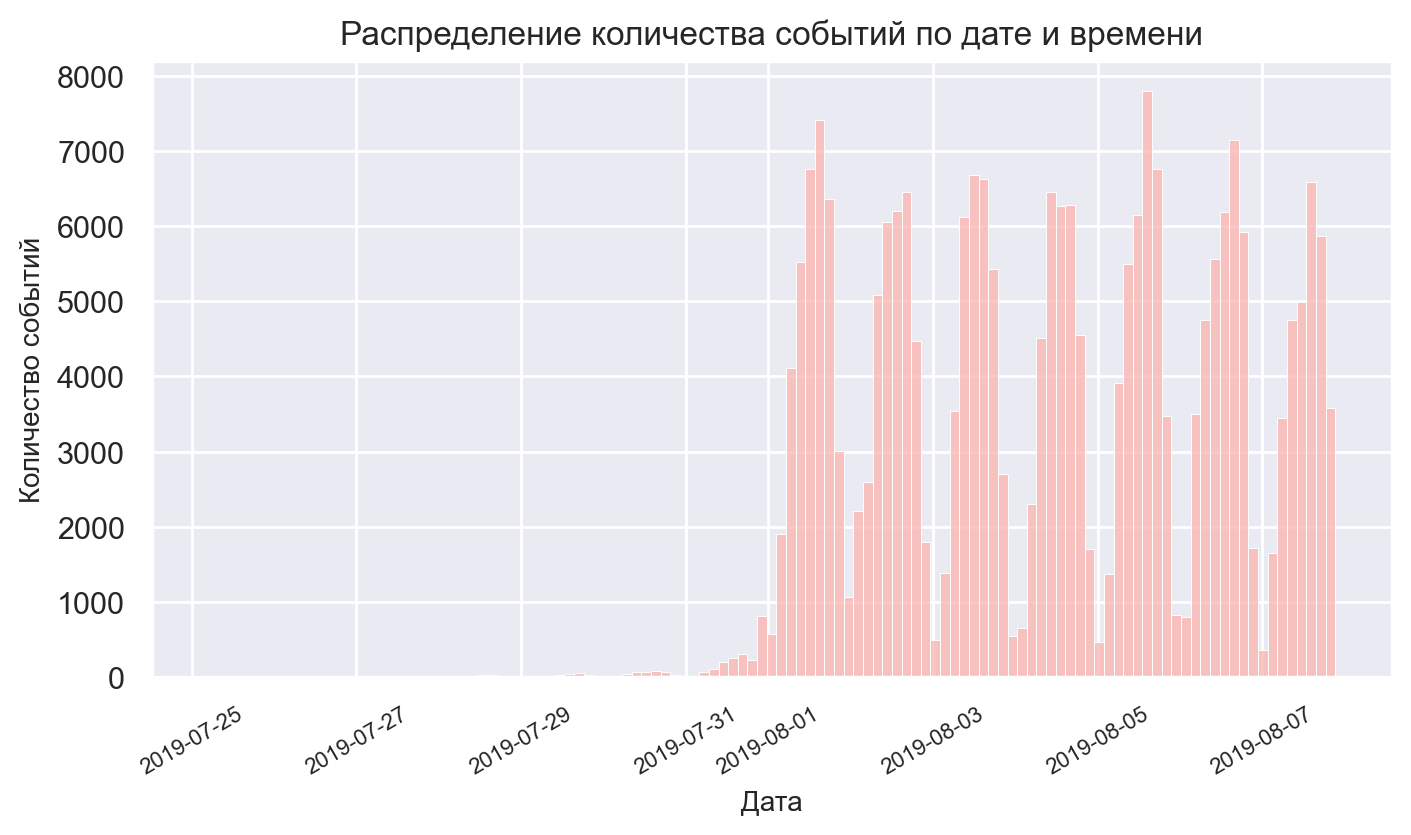

In [17]:
# построение гистограммы
sns.histplot(data['event_dt'])
plt.title('Распределение количества событий по дате и времени')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Количество событий', fontsize=10)
plt.xticks(fontsize=8, rotation=30);

На графике отчетливо видно, что количество событий до 1 августа 2019 года значительно ниже, что говорит о неполноте данных. Таким образом, имеет смысл избавиться от данных за период с 25 по 31 июля 2019 включительно.

In [18]:
# удаление из датафрейма записей с датой до 1 августа 2019
data = data[data['event_date'] >= '2019-08-01'].reset_index(drop=True)

Проверим, много ли событий и пользователей мы потеряли, отбросив старые данные.

In [19]:
print('Потеряно событий:', prev_event_count - data.shape[0], '(-{:.2%})'.format((prev_event_count - data.shape[0]) / prev_event_count))
print('Потеряно пользователей:', prev_user_count - data['user_id'].nunique(), '(-{:.2%})'.format((prev_user_count - data['user_id'].nunique()) / prev_user_count))

Потеряно событий: 2826 (-1.16%)
Потеряно пользователей: 17 (-0.23%)


### Проверка наличия пользователей из всех трёх экспериментальных групп

In [20]:
# расчет количества пользователей в каждой из трех групп
data.groupby('exp_id')['user_id'].count()

exp_id
246    79302
247    77022
248    84563
Name: user_id, dtype: int64

В данных присутствуют пользователи из всех трех групп.

## Изучение воронки событий

Посмотрим, какие события есть в логах и как часто они встречаются.

In [21]:
# создание датафрейма с частотой событий
events = (data.groupby('event_name', as_index=False).
          agg({'user_id': 'count'}).
          sort_values(by='user_id', ascending=False).
          reset_index(drop=True))
events

,event_name,user_id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


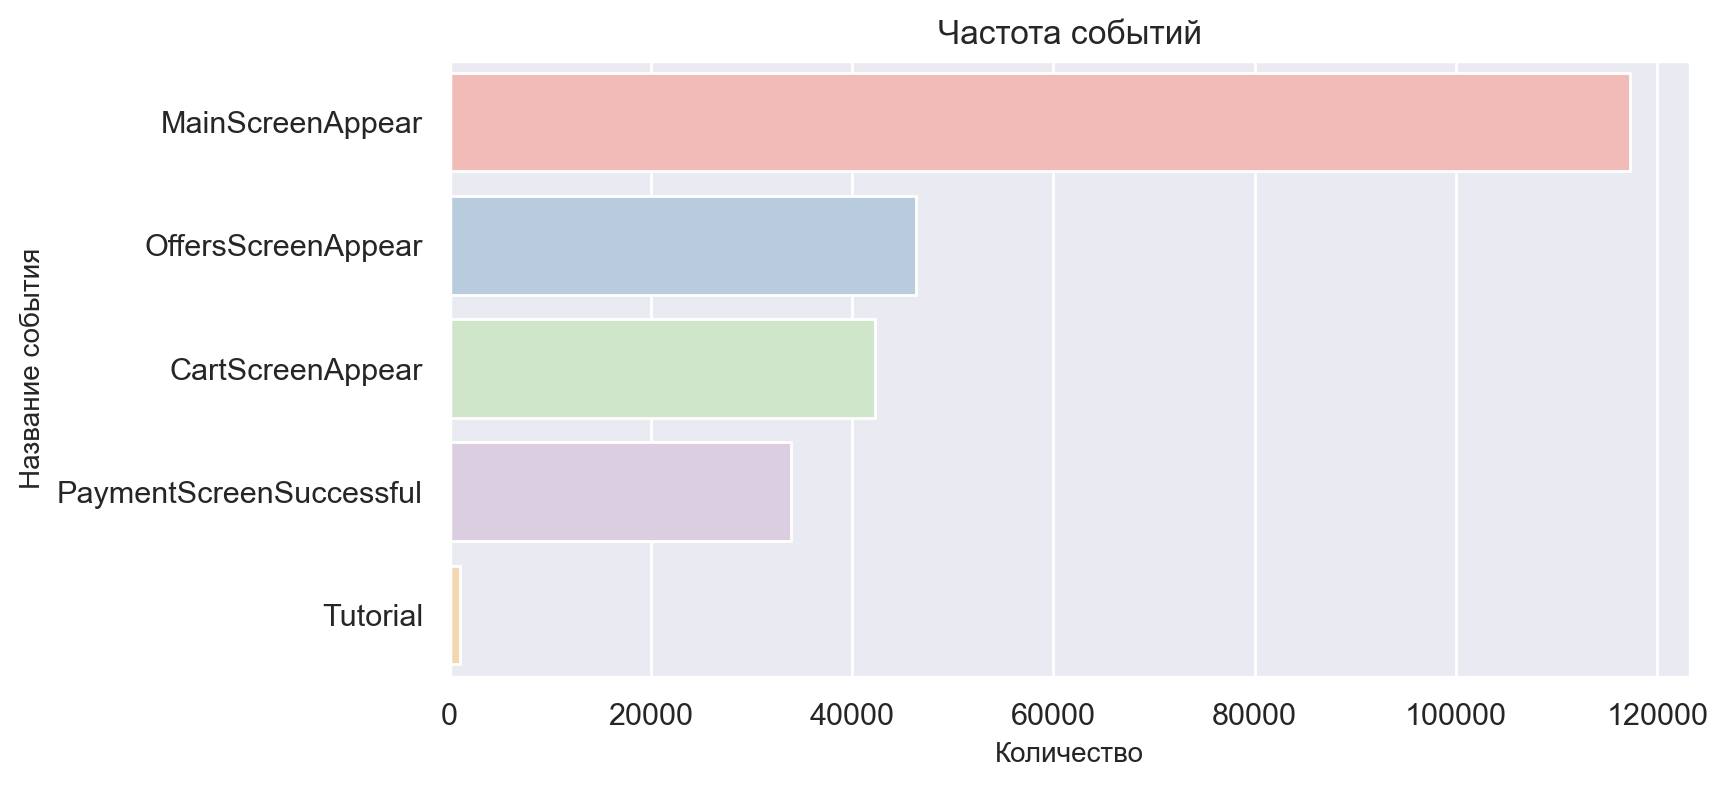

In [22]:
# построение графика с частотой событий
sns.barplot(x=events['user_id'], y=events['event_name'])
plt.title('Частота событий')
plt.xlabel('Количество', fontsize=10)
plt.ylabel('Название события', fontsize=10);

Всего в логах есть 5 видов событий:
- MainScreenAppear;
- OffersScreenAppear;
- CartScreenAppear;
- PaymentScreenSuccessful;
- Tutorial.

Самым часто встречающимся событием является MainScreenAppear, наиболее редким - Tutorial.

Посчитаем, сколько пользователей совершали каждое из событий.

In [23]:
# создание датафрейма с количеством пользователей
user_events = (data.groupby('event_name', as_index=False).
          agg({'user_id': 'nunique'}).
          sort_values(by='user_id', ascending=False).
          reset_index(drop=True))
user_events

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Добавим долю пользователей, которые хоть раз совершали событие.

In [24]:
# добавление столбца с долей
user_events['share'] = (user_events['user_id'] / data['user_id'].nunique() * 100).round()
user_events

,event_name,user_id,share
0,MainScreenAppear,7419,98.0
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0


- главную страницу увидели 98% пользователей;
- страницу с предложениями - 61% пользователей;
- в корзину перешли 50% пользователей;
- на страницу оплаты - 47%;
- на страницу с инструкцией - 11% пользователей.

Можно предположить, что события происходят в следующем порядке:
1. Переход на главную страницу
2. Переход на страницу с предложениями
3. Переход в корзину
4. Переход на страницу оплаты

Последнее событие (переход на страницу с инструкцией) не вписывается в последовательную цепочку, поэтому не будем учитывать его при расчёте воронки.

In [25]:
# удаление из датафрейма события с переходом на страницу с инструкцией
user_events = user_events.query('event_name != "Tutorial"')

In [26]:
# добавление нового столбца с долей пользователей, перешедших на следующий шаг
user_events['new_share'] = ((user_events['user_id'].pct_change() + 1) * 100).round()
user_events['new_share'] = user_events['new_share'].fillna(100)
user_events

,event_name,user_id,share,new_share
0,MainScreenAppear,7419,98.0,100.0
1,OffersScreenAppear,4593,61.0,62.0
2,CartScreenAppear,3734,50.0,81.0
3,PaymentScreenSuccessful,3539,47.0,95.0


Таким образом:
- с главной страницы на страницу с предложениями перешло 62% пользователей;
- со страницы с предложениями в корзину перешел 81% пользователей;
- из корзины на страницу с оплатой перешло 95% пользователей.

Можно сделать вывод о том, что больше всего пользователей теряется на втором шаге (при переходе с главной страницы на страницу с предложениями).

От первого события до оплаты доходит только 48% пользователей.

## Изучение результатов эксперимента

Посмотрим, сколько пользователей в каждой экспериментальной группе.

In [27]:
# расчет количества пользователей в каждой из трех групп
total_users = data.groupby('exp_id', as_index=False)['user_id'].nunique()
total_users

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


In [28]:
# создание датафрейма с количеством пользователей по группам эксперимента и событиям
tests = (data.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique').
         sort_values(by=246, ascending=False).
         reset_index().
         query('event_name != "Tutorial"'))
tests

exp_id,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Чтобы проверить корректность всех механизмов и расчётов, проверим, находят ли статистические критерии разницу между выборками 246 и 247 (контрольными группами для А/А-эксперимента), для этого проведем z-тест.

Сформулируем гипотезы:
- **Нулевая гипотеза**: статистически значимых различий в долях нет; 
- **Альтернативная гипотеза**: статистически значимые различия в долях есть.

In [29]:
alpha = 0.05 # критический уровень статистической значимости

def z_test(df, col_1, col_2, col_3=None):
    for i in df.index:
        if col_3 is None:
            successes = np.array([df.loc[i, col_1], df.loc[i, col_2]])
            trials = np.array([total_users[total_users['exp_id'] == col_1]['user_id'], total_users[total_users['exp_id'] == col_2]['user_id']])
        else:
            successes = np.array([df.loc[i, col_1] + df.loc[i, col_3], df.loc[i, col_2]])
            trials = np.array([total_users.loc[0, 'user_id'] + total_users.loc[1, 'user_id'], total_users[total_users['exp_id'] == col_2]['user_id']])
        
        # пропорция успехов в первой группе
        p1 = successes[0] / trials[0]

        # пропорция успехов во второй группе
        p2 = successes[1] / trials[1]
        
        # пропорция успехов в комбинированном датасете
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        
        # разница пропорций в датасетах
        difference = p1 - p2 
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mt.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1)  
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('Событие:', df.loc[i, 'event_name'])
        print('p-значение:', p_value[0])
        
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [30]:
# выполнение z-теста для 246 и 247 экспериментальной группы
z_test(tests, 246, 247) 

Событие: MainScreenAppear
p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: OffersScreenAppear
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: CartScreenAppear
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: PaymentScreenSuccessful
p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Ни по одному из событий в 246 и 247 группах не наблюдается статистически значимой разницы между долями.

Сравним каждую из контрольных групп с группой с изменённым шрифтом.

In [31]:
# выполнение z-теста для 246 и 248 экспериментальной группы
z_test(tests, 246, 248) 

Событие: MainScreenAppear
p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: OffersScreenAppear
p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: CartScreenAppear
p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: PaymentScreenSuccessful
p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При заданном уровне значимости статистически значимые различия между группами отсутствуют.

In [32]:
# выполнение z-теста для 247 и 248 экспериментальной группы
z_test(tests, 247, 248) 

Событие: MainScreenAppear
p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: OffersScreenAppear
p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: CartScreenAppear
p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: PaymentScreenSuccessful
p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между 247 и 248 группами также нет статически значимых различий.

Сравним результаты с объединённой контрольной группой.

In [33]:
# выполнение z-теста для 246, 247 и 248 экспериментальной группы
z_test(tests, 246, 248, 247) 

Событие: MainScreenAppear
p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: OffersScreenAppear
p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: CartScreenAppear
p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: PaymentScreenSuccessful
p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод не изменился: нулевую гипотезу так же нельзя отвергнуть, т.к. значение p-value больше уровня статистической значимости. Cоответственно, изменение шрифтов в приложении на поведение пользователей не повлияло.

## Общий вывод

В ходе обзора данных датафрейма были обнаружены неверные типы данных некоторых столбцов, явные дубликаты, несоответствующие правильному стилю названия столбцов. Пропущенные значения и пользователи, которые попали сразу в несколько групп, обнаружены не были. Также, были определены события, которые есть в логах: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial.

Во время предобработки данных были исправлены типы данных столбцов для корректной работы с датой и временем, удалены явные дубликаты, добавлен дополнительный столбец с датой, а также переименованы названия столбцов для удобства работы.

В ходе изучения и проверки данных было определено общее количество событий и пользователей в логах, среднее количество событий на пользователя, минимальная и максимальная дата событий. Во время рассмотрения распределения количества событий по датам и времени были обнаружены неполные данные за период с 25 по 31 июля 2019 и было принято решение их из анализа убрать. Удаление данной информации привело к потере 1.2% событий и 0.2% пользователей. Кроме того, была выполнена проверка наличия в датасете пользователей из всех трёх экспериментальных групп.

В ходе изучения воронки событий было определено наиболее часто встречающееся событие - MainScreenAppear и наиболее редкое - Tutorial. На основании анализа частоты событий была сформирована предполагаемая последовательность событий:
1.	Переход на главную страницу
2.	Переход на страницу с предложениями
3.	Переход в корзину
4.	Переход на страницу оплаты

Событие Tutorial не вписалось в цепочку, поэтому при расчёте воронки не учитывалось.

По воронке событий была рассчитана доля пользователей, проходящий на следующий шаг:
-	с главной страницы на страницу с предложениями перешло 62% пользователей;
-	со страницы с предложениями в корзину перешел 81% пользователей;
-	из корзины на страницу с оплатой перешло 95% пользователей.

Таким образом, можно говорить о том, что больше всего пользователей теряется при переходе с главной страницы на страницу с предложениями, а от первого события до оплаты доходит только 48% пользователей.

В ходе изучения результатов эксперимента по изменению шрифта во всем приложении по каждому событию были рассмотрены доли пользователей в разных группах. На основании всех проведенных тестов нельзя говорить о наличии статистически значимых различий между группами. Таким образом, изменение шрифта на поведение пользователей не повлияло.